In [1]:
from keras.datasets import mnist, cifar100
from sklearn.datasets import fetch_lfw_people, fetch_olivetti_faces
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import (
    UpSampling2D,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    AveragePooling2D,
)
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop
import keras
import tensorflow as tf
import keras.backend as K
import keras.backend.tensorflow_backend as KTF

import shutil, os, sys, io, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
os.chdir('/home/k_yonhon/py/Keras-GAN/wgan/')

from tensor_board_logger import TensorBoardLogger
from layer_visualizer import LayerVisualizer
from tqdm import tqdm

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
KTF.set_session(session)

In [2]:
class GAN:
    def __init__(self):
        # ---------------------
        #  for log on TensorBoard
        # ---------------------
        target_dir = "./my_log_dir"
        shutil.rmtree(target_dir, ignore_errors=True)
        os.mkdir(target_dir)
        self.logger = TensorBoardLogger(log_dir=target_dir)

        # ---------------------
        #  Parameter
        # ---------------------
        # self.unrolling_steps = 0
        self.n_critic = 5
        self.clip_value = 10
        
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.input_rows = int(self.img_rows / 16)
        self.input_cols = int(self.img_cols / 16)
        self.latent_dim = 100  # Noiseの次元
        optimizer = RMSprop(lr=0.0005)

        self.discriminator = self.build_discriminator()
        self.generator = self.build_generator()
        
        # https://github.com/tjwei/GANotebooks/blob/master/wgan-keras.ipynb
        # https://keras.io/ja/backend/#function
        img = Input(shape=self.img_shape)
        noise = Input(shape=(self.latent_dim,))

        loss_real = K.mean(self.discriminator(img))
        loss_fake = K.mean(self.discriminator(self.generator(noise)))
        
        loss = loss_fake - loss_real
        training_updates = optimizer.get_updates(self.discriminator.trainable_weights, [], loss)
        self.discriminator_train = K.function([img, noise], [loss], training_updates)

        loss = -loss_fake
        training_updates = optimizer.get_updates(self.generator.trainable_weights, [], loss)
        self.generator_train = K.function([noise], [loss], training_updates)
        
    def build_generator(self):
        model = Sequential()
        model.add(Dense(self.input_rows * self.input_cols * 1024, activation="relu", input_dim=self.latent_dim,
                       kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                       ))
        model.add(Reshape((self.input_rows, self.input_cols, 1024)))
        
        model.add(Conv2DTranspose(512, (5, 5), strides=2, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        # model.add(BatchNormalization(momentum=0.8))
        model.add(ReLU(max_value=None))
        
        model.add(Conv2DTranspose(256, (5, 5), strides=2, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        # model.add(BatchNormalization(momentum=0.8))
        model.add(ReLU(max_value=None))

        model.add(Conv2DTranspose(128, (5, 5), strides=2, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        # model.add(BatchNormalization(momentum=0.8))
        model.add(ReLU(max_value=None))
        
        model.add(Conv2DTranspose(3, (5, 5), strides=2, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))                             
        model.add(Activation("tanh"))
        
        print('<Generator Summary>')
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(64, (5, 5), strides=2, input_shape=self.img_shape, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        # model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        # model.add(Dropout(0.25))
        
        model.add(Conv2D(128, (5, 5), strides=2, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        # model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        # model.add(Dropout(0.25))

        model.add(Conv2D(256, (5, 5), strides=2, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        # model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        # model.add(Dropout(0.25))
        
        model.add(Conv2D(512, (5, 5), strides=2, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        # model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        # model.add(Dropout(0.25))
        
        # model.add(Flatten())
        # model.add(Dense(1))
        model.add(Conv2D(1, (4, 4), strides=1, padding="valid",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(Flatten())
        
        print('<Discriminator Summary>')
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        # ---------------------
        #  Load the dataset
        # ---------------------      
        # Original dataset
        X_train = np.load('/home/k_yonhon/py/Keras-GAN/datasets/lfw.npy')
        X_train = X_train / 127.5 - 1.0   # Rescale -1 to 1
        
        for epoch in tqdm(range(epochs + 1)):
            # ---------------------
            #  Train Discriminator
            # ---------------------
            for _ in range(self.n_critic):
                # Generate a batch of new images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]

                # Generate a batch of new images
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # gen_imgs = self.generator.predict(noise)
              
                d_loss, = self.discriminator_train([imgs, noise])
                
                # Clip critic weights
                for layer in self.discriminator.layers:
                    # discriminator各層の重さを取得し、範囲外の値を最小値、最大値に置換
                    weights = layer.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    layer.set_weights(weights)

            # ---------------------
            #  Train Generator
            # ---------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss, = self.generator_train([noise])

            # ---------------------
            #  Log on TensorBoard
            # ---------------------
            logs = {
                "Discriminator/loss": d_loss,
                "Generator/loss": g_loss,
            }
            histograms = {}
            for layer in self.discriminator.layers[1].layers:
                for i in range(len(layer.get_weights())):
                    if "conv" in layer.name or "dense" in layer.name:
                        name = layer.name + "/" + str(i)
                        value = layer.get_weights()[i]
                        histograms[name] = value
            self.logger.log(logs=logs, histograms=histograms, epoch=epoch)

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                fig, name = self.sample_images(epoch)
                images = {name: fig}
                self.logger.log(images=images, epoch=epoch)
                print("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss, g_loss))

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                if self.channels == 1:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap="gray")
                else:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, :self.channels], cmap="gray")
                axs[i, j].axis("off")
                cnt += 1
        name = str(epoch) + ".png"
        return fig, name
        # fig.savefig("images/%d.png" % epoch)
        # plt.close()

In [3]:
gan = GAN()

<Discriminator Summary>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 512)      

  0%|          | 1/10001 [00:15<44:12:32, 15.92s/it]

0 [D loss: -14297.111328] [G loss: -2498.094482]


  1%|▏         | 148/10001 [02:34<2:31:05,  1.09it/s]

KeyboardInterrupt: 

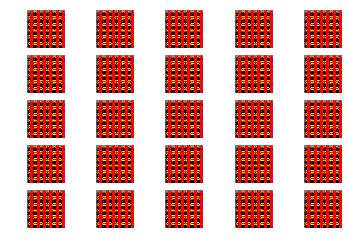

In [4]:
gan.train(epochs=10000, batch_size=64, sample_interval=1000)

In [25]:
for layer in gan.discriminator.layers:
    # print(layer.name)
    weights = layer.get_weights()
    print(weights[-1:])
    # for w in weights:
        # print(w.shape)
        # print(w)

[]
[array([0.], dtype=float32)]


In [5]:
gan.generator.save('./saved_model/dcgan2_generator.h5')
gan.discriminator.save('./saved_model/dcgan2_discriminator.h5')
gan.combined.save('./saved_model/dcgan2_combined.h5')

In [6]:
from keras.models import load_model
generator = load_model('./saved_model/dcgan2_generator.h5')

/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
model = generator.layers[1]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 512)         13107712  
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 256)       3277056   
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 256)       1024      
__________

conv2d_transpose_1


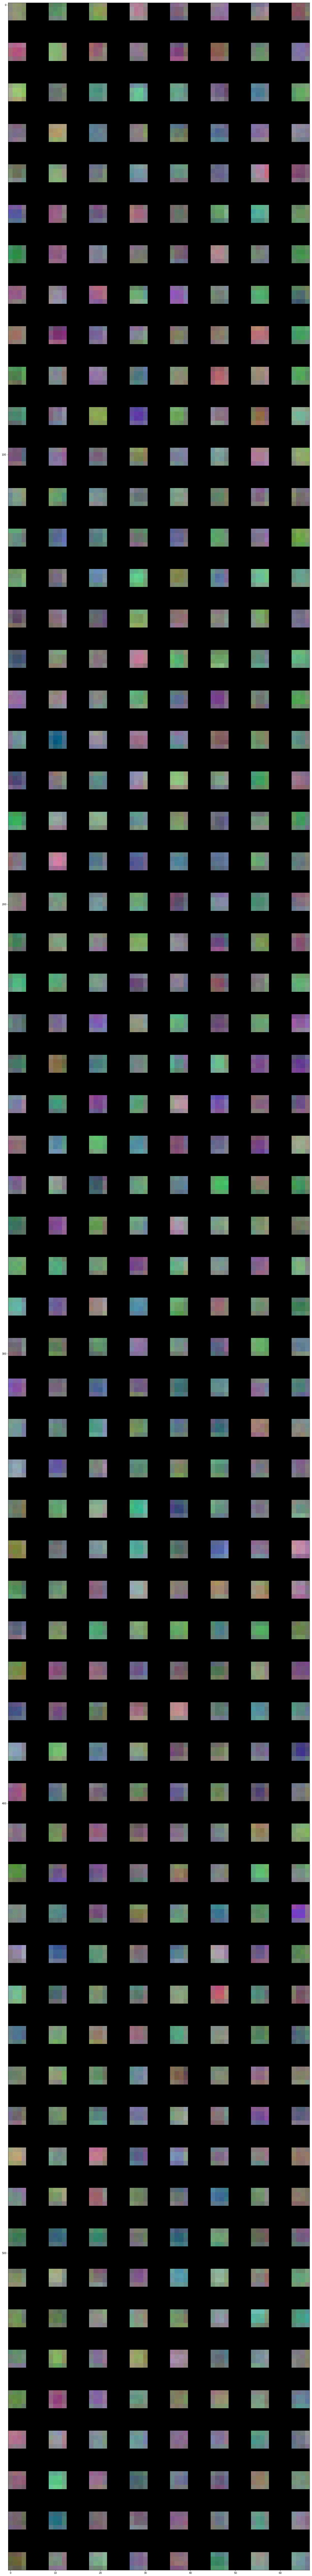

conv2d_transpose_2


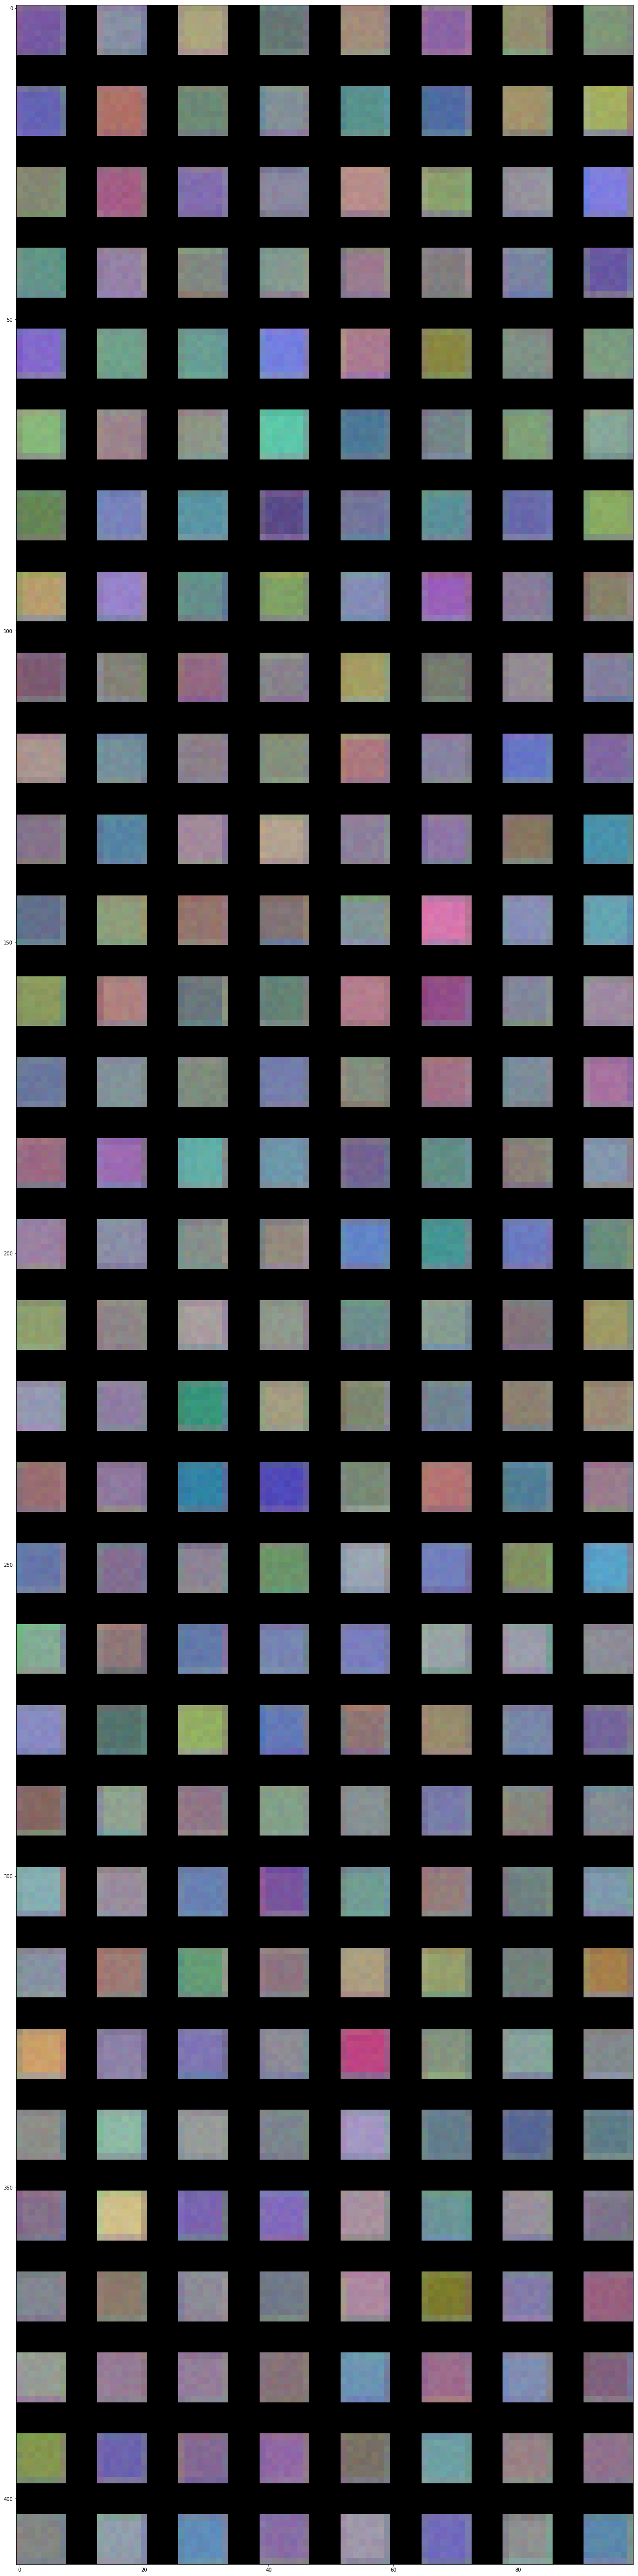

conv2d_transpose_3


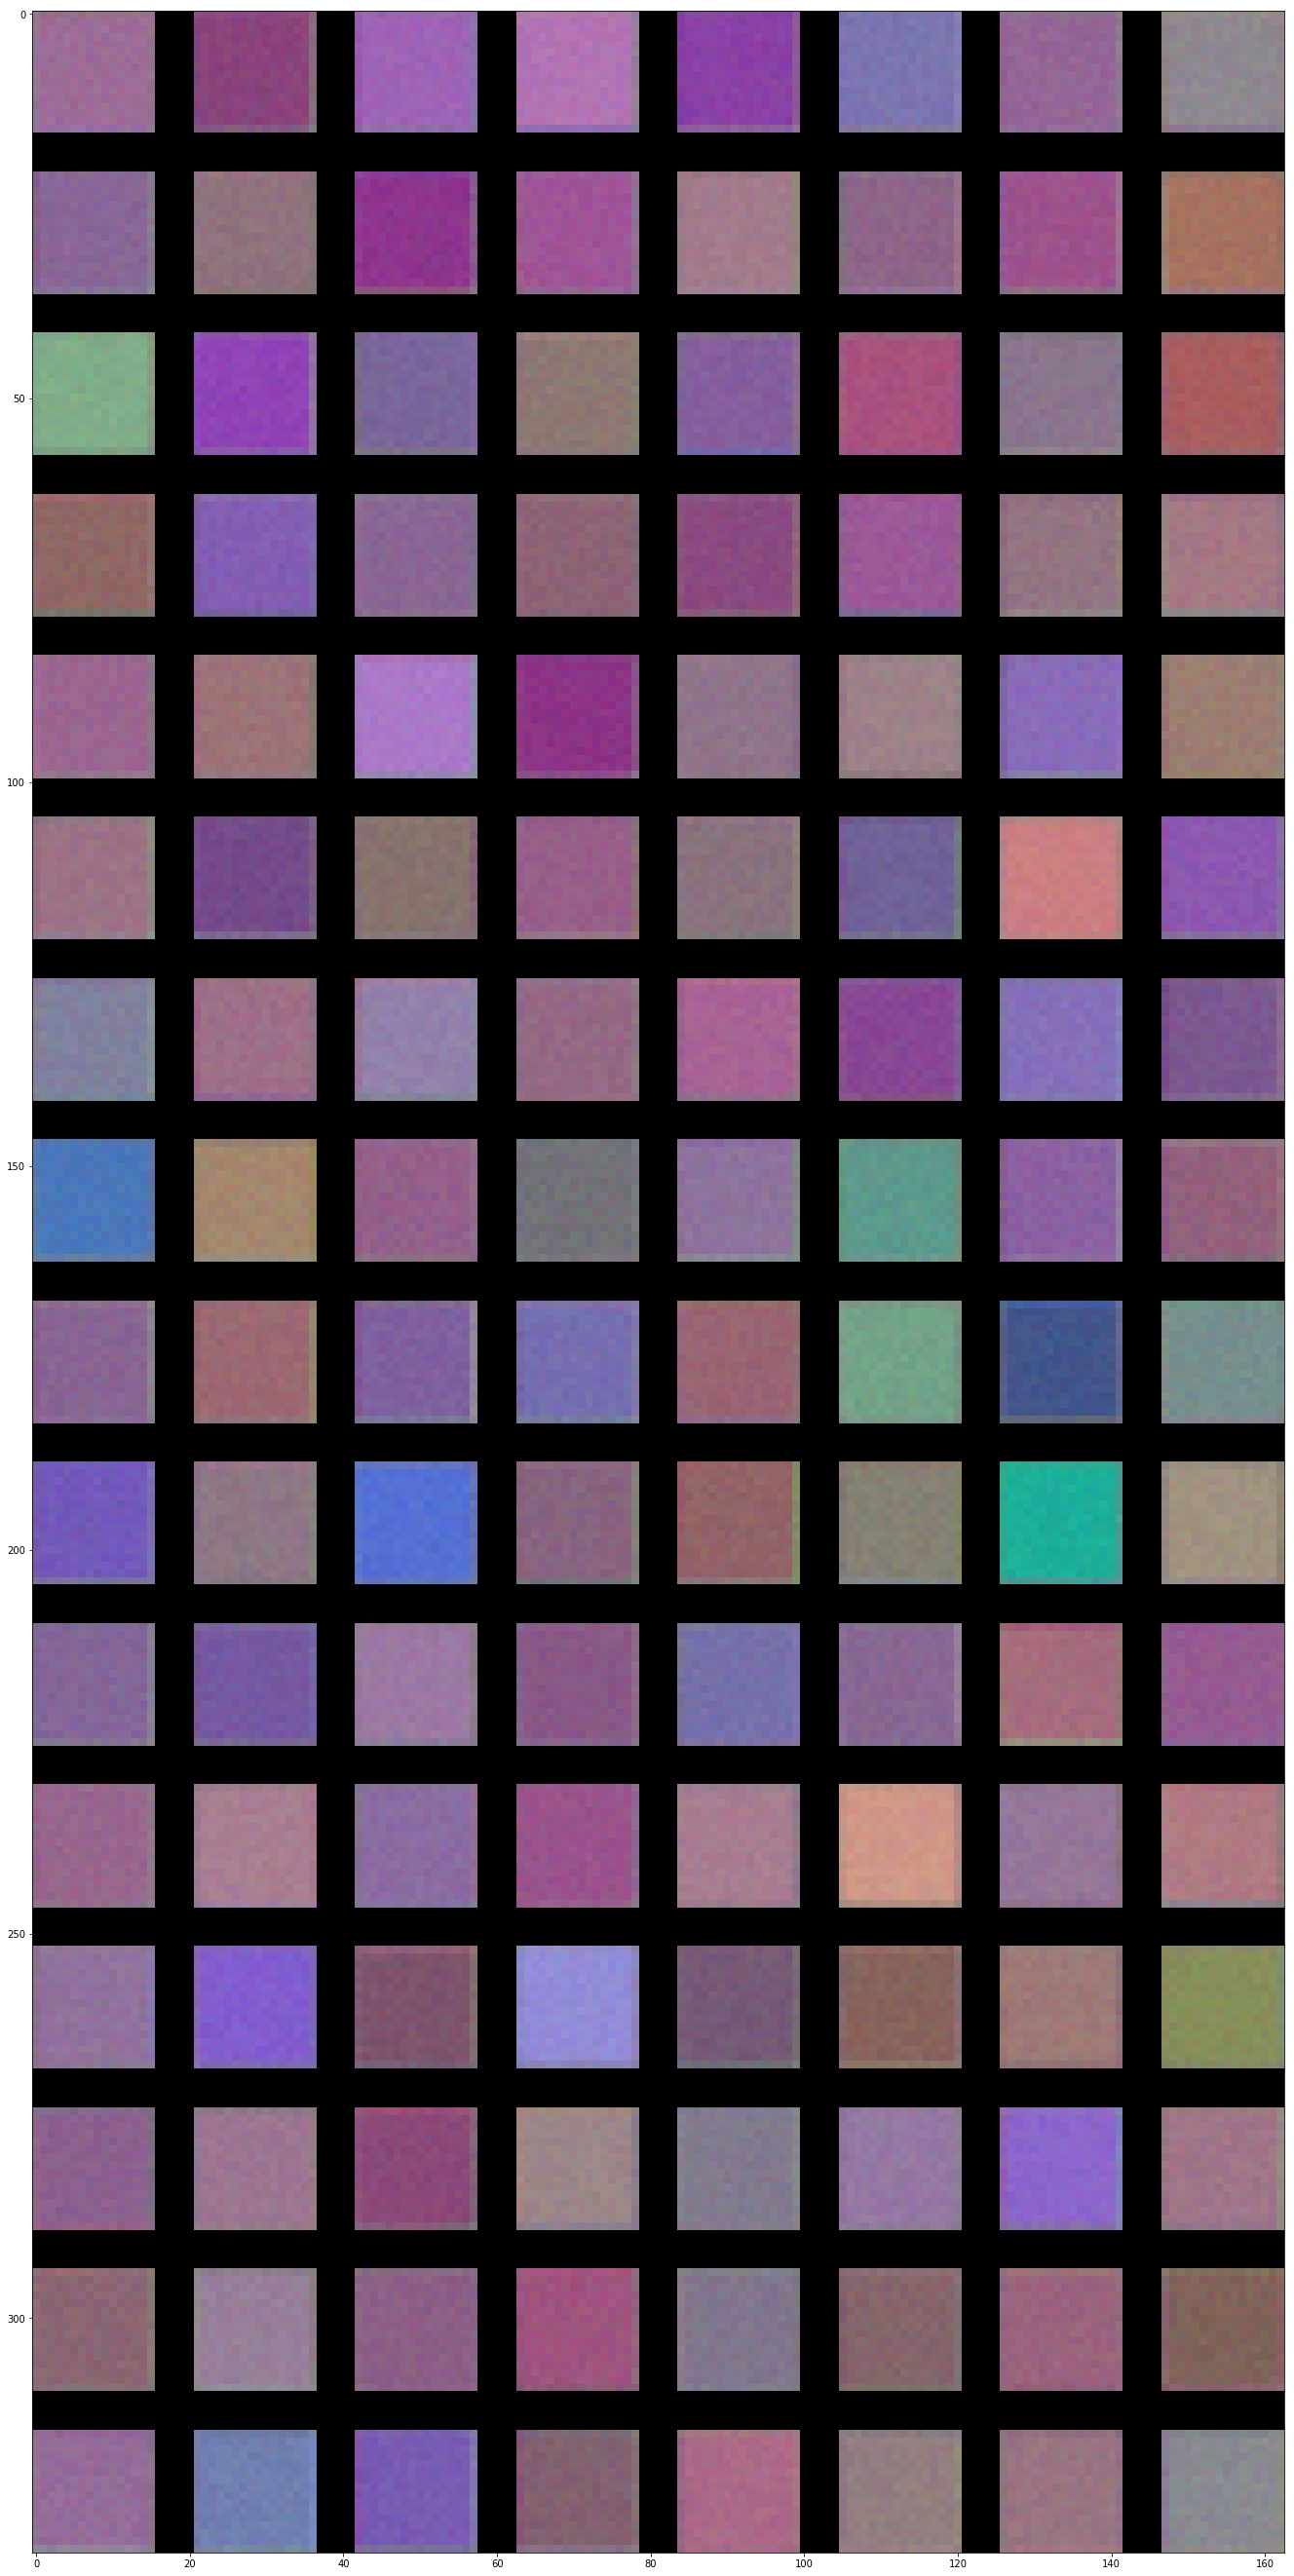

conv2d_transpose_4


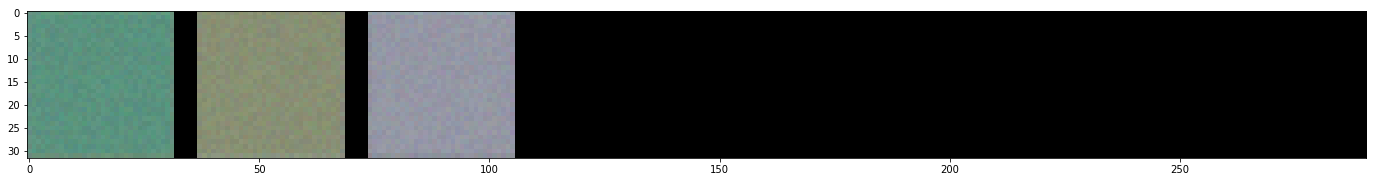

In [9]:
for layer in model.layers:
    if "conv2d" in layer.name:
        LayerVisualizer(model, layer.name)

conv2d_5


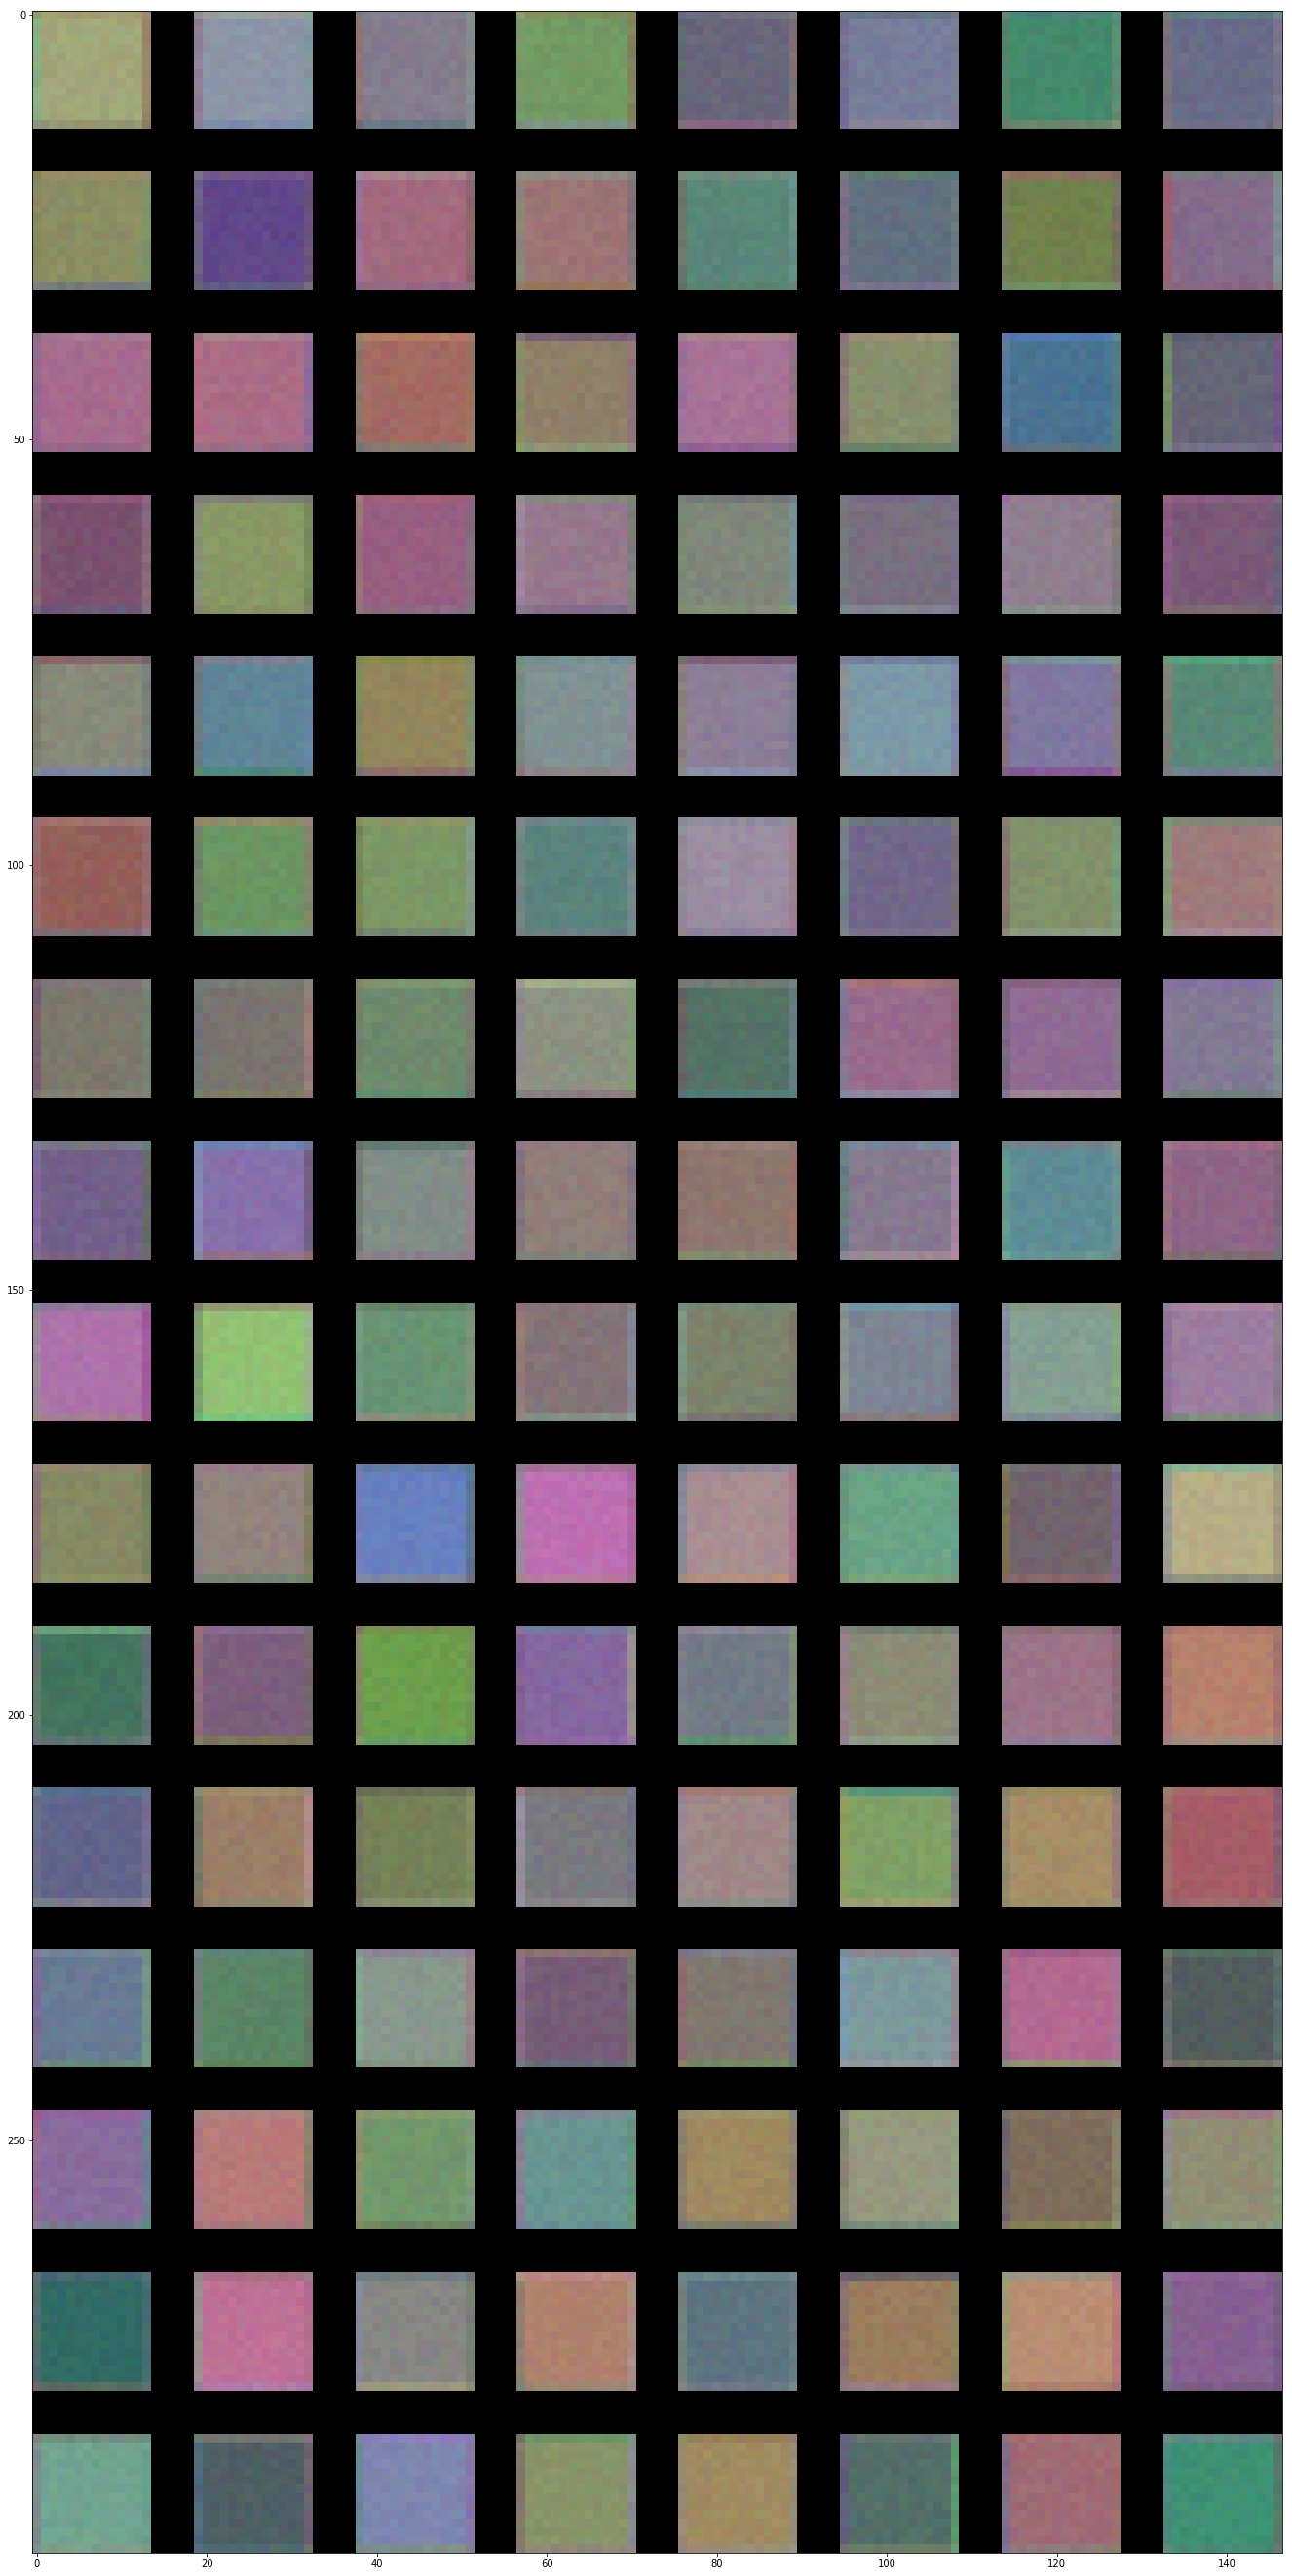

conv2d_6


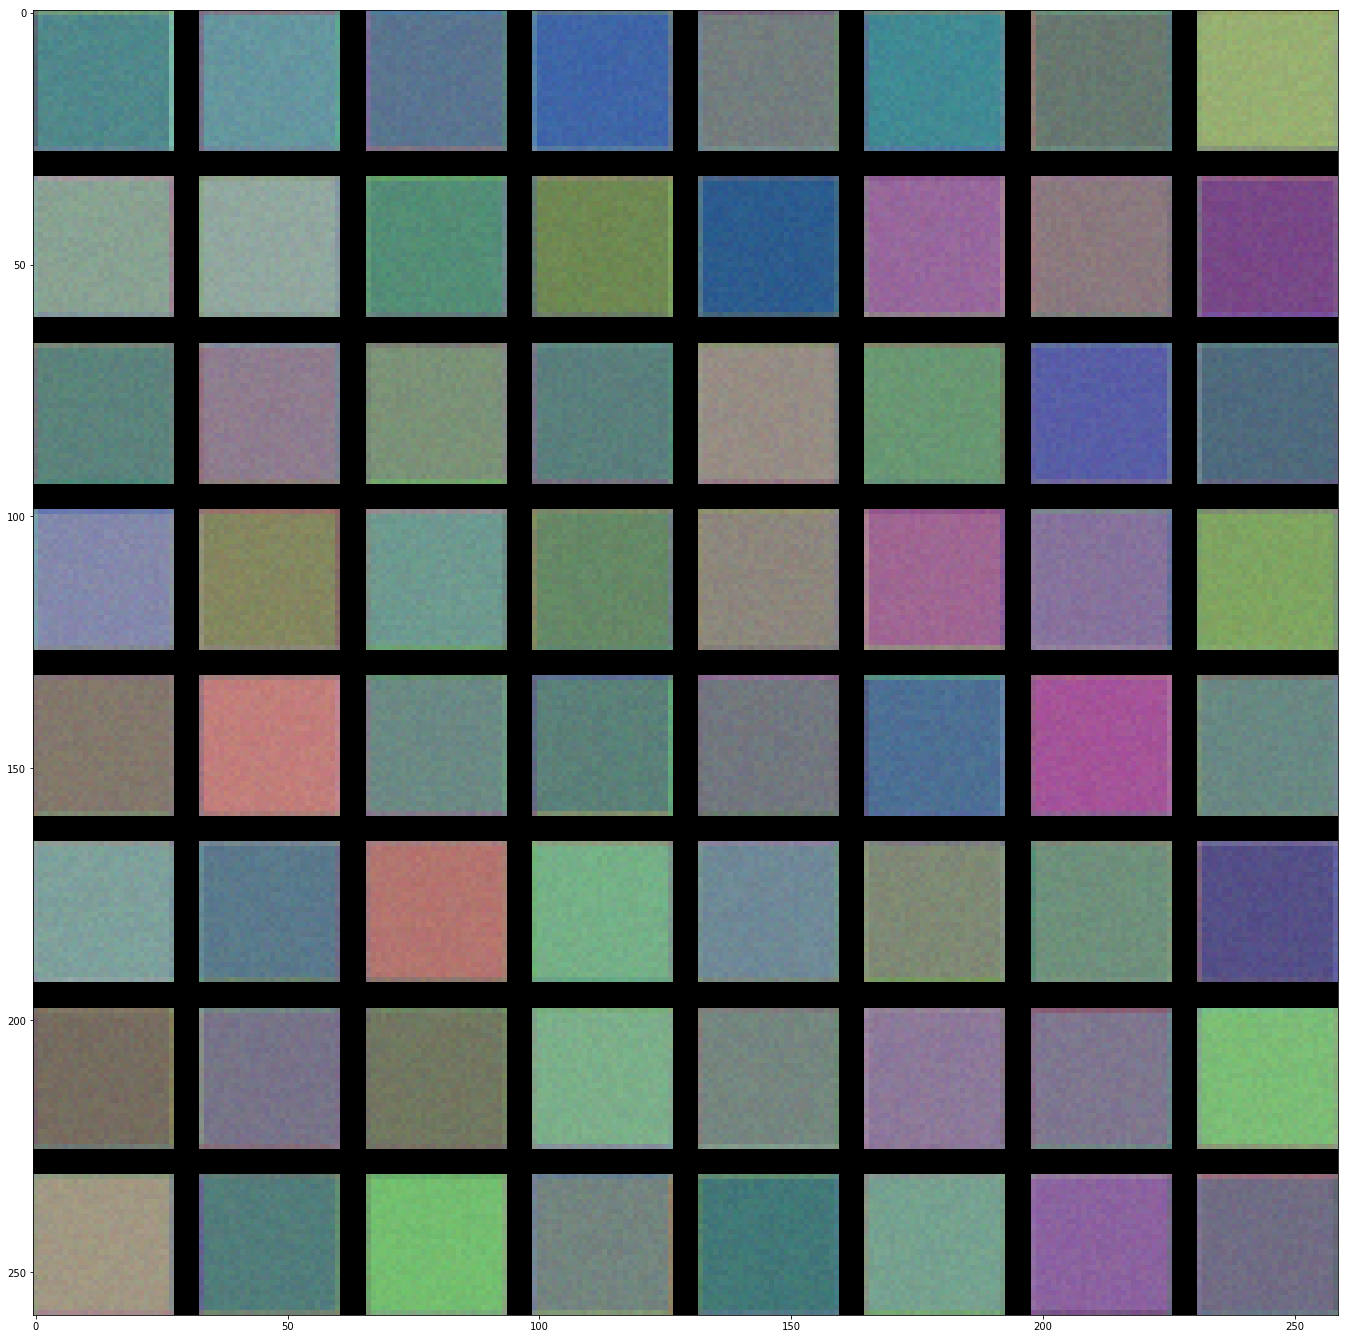

conv2d_7


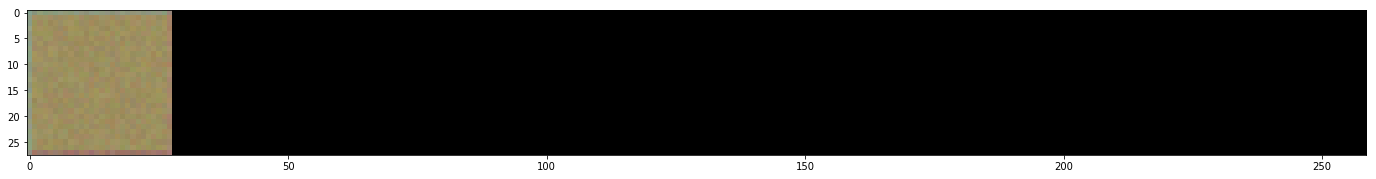

In [7]:
for layer_name in ["conv2d_5", "conv2d_6", "conv2d_7"]:
    LayerVisualizer(model, layer_name)

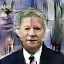

In [19]:
# (X_train, y_train), (_, _) = cifar100.load_data(label_mode='fine')
# X_train = X_train[y_train.flatten() == 8]
noise = np.random.normal(0, 1, (32, 100))
gen_imgs = gan.generator.predict(noise)
gen_imgs = (0.5 * gen_imgs[random.randint(0, 32)] + 0.5) * 255
gen_imgs = gen_imgs.astype('uint8')
img = Image.fromarray(gen_imgs)
img.save("dcgan.png")
img